# EBAC - Regressão II - regressão múltipla

## Tarefa I

#### Previsão de renda II

Vamos continuar trabalhando com a base 'previsao_de_renda.csv', que é a base do seu próximo projeto. Vamos usar os recursos que vimos até aqui nesta base.

|variavel|descrição|
|-|-|
|data_ref                | Data de referência de coleta das variáveis |
|index                   | Código de identificação do cliente|
|sexo                    | Sexo do cliente|
|posse_de_veiculo        | Indica se o cliente possui veículo|
|posse_de_imovel         | Indica se o cliente possui imóvel|
|qtd_filhos              | Quantidade de filhos do cliente|
|tipo_renda              | Tipo de renda do cliente|
|educacao                | Grau de instrução do cliente|
|estado_civil            | Estado civil do cliente|
|tipo_residencia         | Tipo de residência do cliente (própria, alugada etc)|
|idade                   | Idade do cliente|
|tempo_emprego           | Tempo no emprego atual|
|qt_pessoas_residencia   | Quantidade de pessoas que moram na residência|
|renda                   | Renda em reais|

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import patsy
import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.model_selection import train_test_split
from lib import stepwise_selection

In [2]:
df = pd.read_csv('previsao_de_renda.csv').dropna().drop_duplicates()
df.drop('Unnamed: 0', axis=1, inplace=True)
df.drop('data_ref', axis=1, inplace=True)
df.drop('id_cliente', axis=1, inplace=True)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12427 entries, 0 to 14999
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   sexo                   12427 non-null  object 
 1   posse_de_veiculo       12427 non-null  bool   
 2   posse_de_imovel        12427 non-null  bool   
 3   qtd_filhos             12427 non-null  int64  
 4   tipo_renda             12427 non-null  object 
 5   educacao               12427 non-null  object 
 6   estado_civil           12427 non-null  object 
 7   tipo_residencia        12427 non-null  object 
 8   idade                  12427 non-null  int64  
 9   tempo_emprego          12427 non-null  float64
 10  qt_pessoas_residencia  12427 non-null  float64
 11  renda                  12427 non-null  float64
dtypes: bool(2), float64(3), int64(2), object(5)
memory usage: 1.1+ MB


1. Separe a base em treinamento e teste (25% para teste, 75% para treinamento).
2. Rode uma regularização *ridge* com alpha = [0, 0.001, 0.005, 0.01, 0.05, 0.1] e avalie o $R^2$ na base de testes. Qual o melhor modelo?
3. Faça o mesmo que no passo 2, com uma regressão *LASSO*. Qual método chega a um melhor resultado?
4. Rode um modelo *stepwise*. Avalie o $R^2$ na vase de testes. Qual o melhor resultado?
5. Compare os parâmetros e avalie eventuais diferenças. Qual modelo você acha o melhor de todos?
6. Partindo dos modelos que você ajustou, tente melhorar o $R^2$ na base de testes. Use a criatividade, veja se consegue inserir alguma transformação ou combinação de variáveis.
7. Ajuste uma árvore de regressão e veja se consegue um $R^2$ melhor com ela.

##### Parte 1

In [4]:
df_X = df.drop('renda', axis=1)
df_y = df['renda'].to_frame()
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, train_size=.75)
df_train = pd.concat([X_train, y_train], axis=1)

##### Parte 2

In [5]:
alphas = [0, .001, .005, .01, .05, .1]
r_quadrados = []
for alpha in alphas:
    reg = smf.ols('np.log(renda) ~ '
        'sexo + posse_de_veiculo + C(posse_de_imovel, Treatment(True)) + '
        'qtd_filhos + tipo_renda + C(educacao, Treatment("Secundário")) + '
        'estado_civil + C(tipo_residencia, Treatment("Casa")) + idade + '
        'tempo_emprego + qt_pessoas_residencia',
        data = df_train
    )
    reg = reg.fit_regularized(method='elastic_net', refit=True, L1_wt=0, alpha=alpha)
    y_pred = np.exp(reg.predict(X_test))
    y_real = y_test['renda']
    r_quadrado = y_real.corr(y_pred) ** 2
    r_quadrados.append(r_quadrado)

Text(0, 0.5, 'R Quadrado')

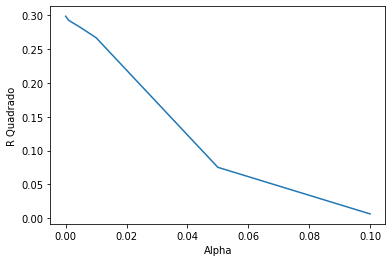

In [6]:
graf = sns.lineplot(x=alphas, y=r_quadrados, markers='o')
graf.set_xlabel('Alpha')
graf.set_ylabel('R Quadrado')

Se considerarmos apenas o $R^2$, o melhor modelo é o de $\alpha = 0$.

##### Parte 3

In [7]:
alphas = [0, .001, .005, .01, .05, .1]
r_quadrados = []
for alpha in alphas:
    reg = smf.ols('np.log(renda) ~ '
        'sexo + posse_de_veiculo + C(posse_de_imovel, Treatment(True)) + '
        'qtd_filhos + tipo_renda + C(educacao, Treatment("Secundário")) + '
        'estado_civil + C(tipo_residencia, Treatment("Casa")) + idade + '
        'tempo_emprego + qt_pessoas_residencia',
        data = df_train
    )
    reg = reg.fit_regularized(method='elastic_net', refit=True, L1_wt=1, alpha=alpha)
    y_pred = np.exp(reg.predict(X_test))
    y_real = y_test['renda']
    r_quadrado = y_real.corr(y_pred) ** 2
    r_quadrados.append(r_quadrado)

Text(0, 0.5, 'R Quadrado')

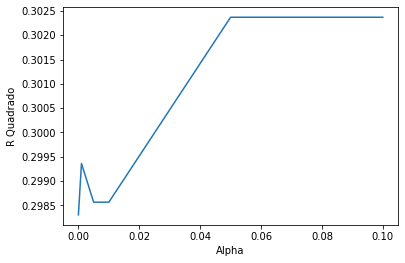

In [8]:
graf = sns.lineplot(x=alphas, y=r_quadrados, markers='o')
graf.set_xlabel('Alpha')
graf.set_ylabel('R Quadrado')

Os melhores resultados foram $\alpha = 0.05$ e $\alpha = 0.1$

##### Parte 4

In [10]:
stepwise_selection(X_train, y_train)

ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).